In [1]:
# Imports

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.transforms as tr
from model.change_detction_dataset import ChangeDetectionDataset, RandomFlip, RandomRot

# Models
from model.unet import Unet
from model.siamunet_conc import SiamUnet_conc
from model.siamunet_diff import SiamUnet_diff
from model.fresunet import FresUNet
from model.model import Model, ModelConfig

# Other
import numpy as np
from skimage import io

%matplotlib inline
from tqdm import tqdm as tqdm
import time
import warnings
from pprint import pprint


In [2]:
# Global Variables' Definitions
PATH_TO_DATASET = './dataset-lite/'
MODEL_TYPE = 1 # 0-FC-EF | 1-FC-Siam-diff | 2-FC-Siam-conc | 3-FresUNet
GPU_ENABLED = torch.cuda.is_available()
LOAD_TRAINED = False


#Cofniguration
DATA_AUG = True
BATCH_SIZE = 32
PATCH_SIDE = 96
N_EPOCHS = 2
NORMALISE_IMGS = True
TRAIN_STRIDE = int(PATCH_SIDE/2) - 1

In [3]:
# Dataset
if DATA_AUG:
    data_transform = tr.Compose([RandomFlip(), RandomRot()])
else:
    data_transform = None


train_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = True, stride = TRAIN_STRIDE, transform=data_transform)
weights = torch.FloatTensor(train_dataset.weights)
if GPU_ENABLED:
  print(f'GPU ENABLED')
  weights = weights.cuda()
  
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
test_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = False, stride = TRAIN_STRIDE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)



499it [00:03, 145.68it/s]


GPU ENABLED


499it [00:03, 145.87it/s]


In [4]:
# 0-FC-EF | 1-FC-Siam-diff | 2-FC-Siam-conc | 3-FresUNet
if MODEL_TYPE == 0:
    net, net_name = Unet(2*3, 2), 'FC-EF'
elif MODEL_TYPE == 1:
    net, net_name = SiamUnet_diff(3, 2), 'FC-Siam-diff'
elif MODEL_TYPE == 2:
    net, net_name = SiamUnet_conc(3, 2), 'FC-Siam-conc'
elif MODEL_TYPE == 3:
    net, net_name = FresUNet(2*3, 2), 'FresUNet'

if GPU_ENABLED:
    net.cuda()

criterion = nn.NLLLoss(weight=weights) # to be used with logsoftmax output

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(net))

Number of trainable parameters: 1350146


In [6]:
model_config = ModelConfig(n_epochs=N_EPOCHS, gpu_enabled=GPU_ENABLED)
model = Model(
    model=net,
    model_name=net_name,
    config=model_config,
    train_dataset=train_dataset,
    train_loader=train_loader,
    test_dataset=test_dataset,
    criterion=criterion,
)

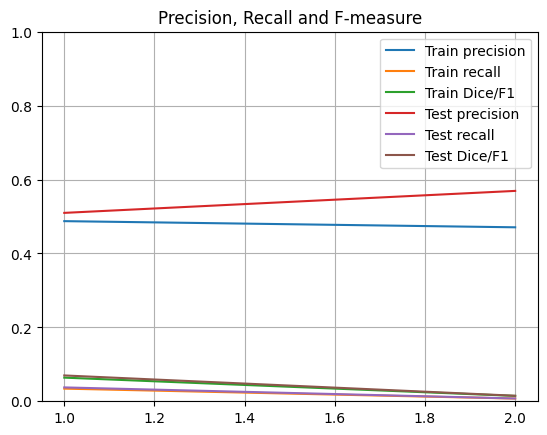

{'train_loss': 0.3098028898239136, 'train_accuracy': 87.34195203666228, 'train_nochange_accuracy': 0.9988018384040974, 'train_change_accuracy': 0.007360291591498608, 'test_loss': 0.3330823481082916, 'test_accuracy': 86.02869730876631, 'test_nochange_accuracy': 0.9990672175861585, 'test_change_accuracy': 0.007572976502648626}
Elapsed time:
96.64568781852722


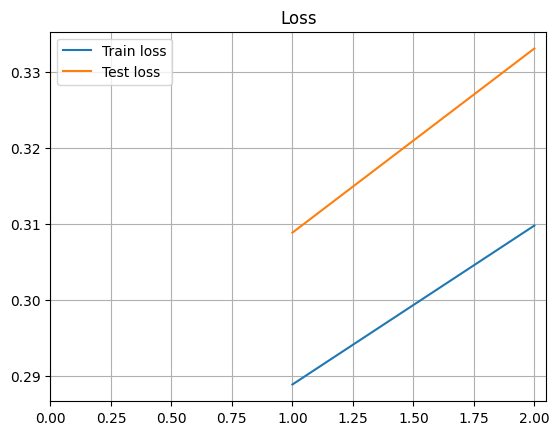

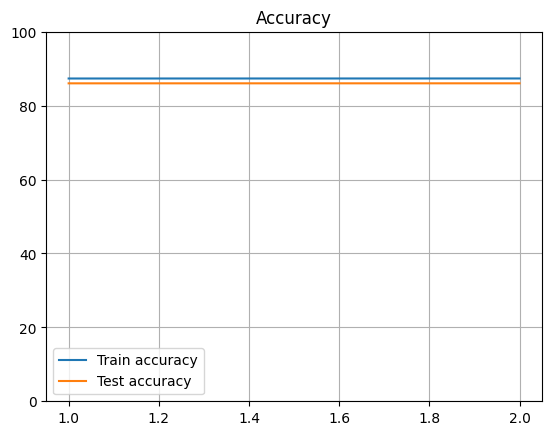

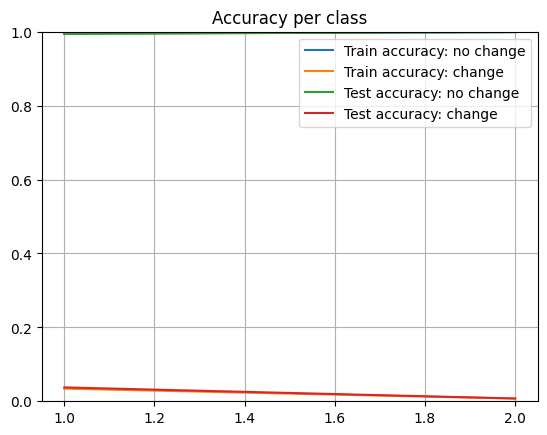

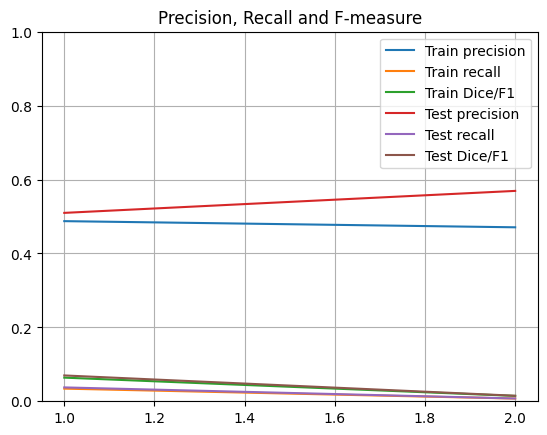

In [7]:
from matplotlib import pyplot as plt

if LOAD_TRAINED:
    net.load_state_dict(torch.load('siam_diff.tar'))
    print('LOAD OK')
else:
    t_start = time.time()
    out_dic = model.train()
    t_end = time.time()
    print(out_dic)
    print('Elapsed time:')
    print(t_end - t_start)


In [8]:
if not LOAD_TRAINED:
    torch.save(model.model.state_dict(), 'net_final.pth.tar')
    print('SAVE OK')

SAVE OK


In [9]:
# Inference on test images
def save_test_results(dset):
    for idx, name in tqdm(dset.names.iterrows()):
        name = name[0]
        with warnings.catch_warnings():
            I1, I2, cm = dset.get_img(name)
            I1 = Variable(torch.unsqueeze(I1, 0).float())
            I2 = Variable(torch.unsqueeze(I2, 0).float())

            if GPU_ENABLED:
                I1 = I1.cuda()
                I2 = I2.cuda()

            out = net(I1, I2)
            _, predicted = torch.max(out.data, 1)
            I = np.stack((255*cm,255*np.squeeze(predicted.cpu().numpy()),255*cm),2)
            I = I.astype(np.uint8)
            io.imsave(f'{net_name}-{name}',I, check_contrast=False)

t_start = time.time()
save_test_results(test_dataset)
t_end = time.time()
print('Elapsed time: {}'.format(t_end - t_start))


499it [00:08, 57.41it/s]

Elapsed time: 8.69616961479187


In [10]:
results_train = model.evaluate(train_dataset)
results_test = model.evaluate(test_dataset)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [11]:
print('Train Performance:')
print(results_train)
print('Test Performance:')
print(results_test)

Train Performance:
{'net_loss': 0.3094836175441742, 'net_accuracy': 87.3662455526287, 'class_accuracy': [0.9988036978140118, 0.0073597102921111384], 'precision': 0.4705326580239456, 'recall': 0.0073597102921111384, 'dice': 0.014492736338250038, 'kappa': 0.010646425084796091}
Test Performance:
{'net_loss': 0.3330167829990387, 'net_accuracy': 86.03410739936905, 'class_accuracy': [0.999068755118327, 0.007561853117341165], 'precision': 0.569144473870347, 'recall': 0.007561853117341165, 'dice': 0.014925402106940508, 'kappa': 0.011297659511006704}
